In [50]:
# 5 КАРМАНОВ

In [51]:
import pandas as pd
import numpy as np
import prophet
from make_series import *
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import warnings
from statsmodels.tsa.arima.model import ARIMA


warnings.filterwarnings("ignore")

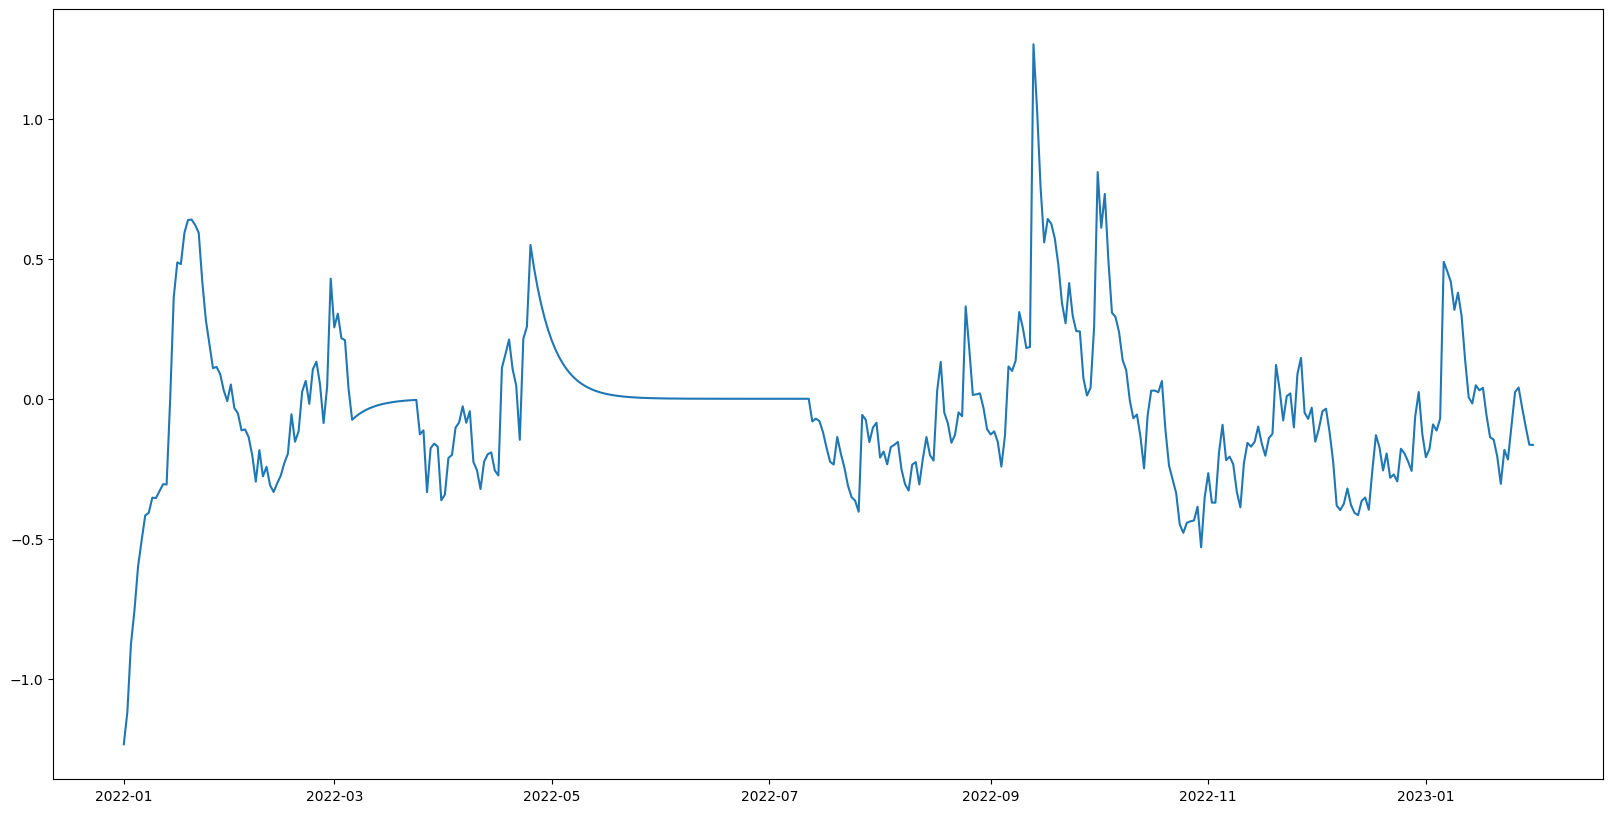

In [52]:
# Соберем нужные данные
df = pd.read_excel('../data/normalized_data.xlsx')
series = make_series(df,['Готовая женская одежда' ,"Одежда для всей семьи","Детская одежда, включая одежду для самых маленьких",'Спортивная одежда, одежда для верховой езды и езды на мотоцикле','Магазины мужской и женской одежды'], is_exponential_smoothing=True)
series_diff = [0.4]
for i in range(1, len(series)):
    series_diff.append(series[i] / series[i-1])

dates = get_all_dates()

# Сделаем из 2 столбцов датафрейм
df = pd.DataFrame({'ds': dates, 'y': series})


df['ds'] = pd.to_datetime(df['ds'])

# Сделаем график series
plt.figure(figsize=(20, 10))
plt.plot(df['ds'], df['y'])
plt.show()

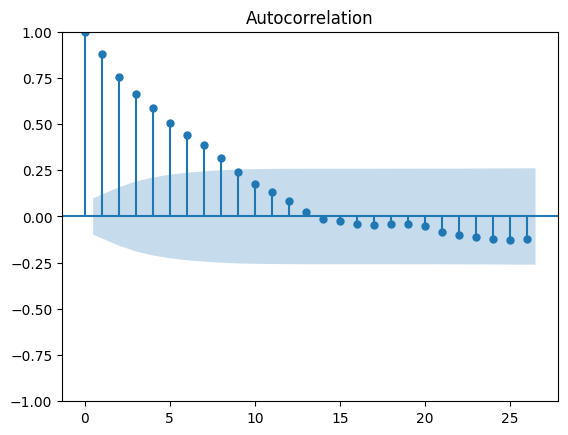

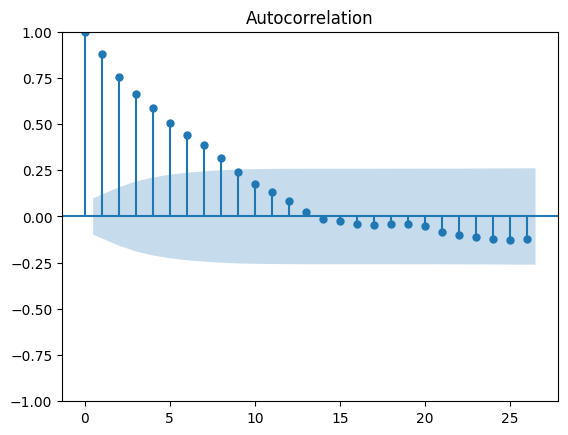

In [53]:
# Построим график автолкорреляции на всех данных
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(np.array(series))


In [54]:
test_stationarity(series)

Results of Dickey-Fuller Test:
Test Statistic                -5.700994e+00
p-value                        7.676751e-07
#Lags Used                     0.000000e+00
Number of Observations Used    3.950000e+02
Critical Value (1%)           -3.447014e+00
Critical Value (5%)           -2.868885e+00
Critical Value (10%)          -2.570683e+00
dtype: float64


In [55]:
# Создадим модель prophet
model = prophet.Prophet()
# Добавим сезонность
model.add_seasonality(name='monthly', period=300.                        , fourier_order=50)
model.fit(df)



14:27:11 - cmdstanpy - INFO - Chain [1] start processing
14:27:11 - cmdstanpy - INFO - Chain [1] done processing


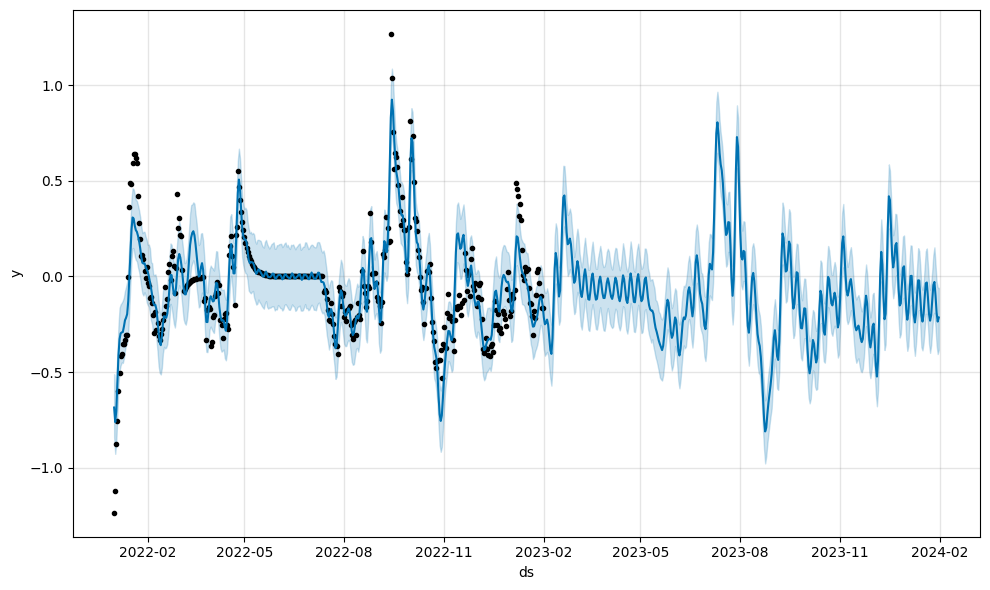

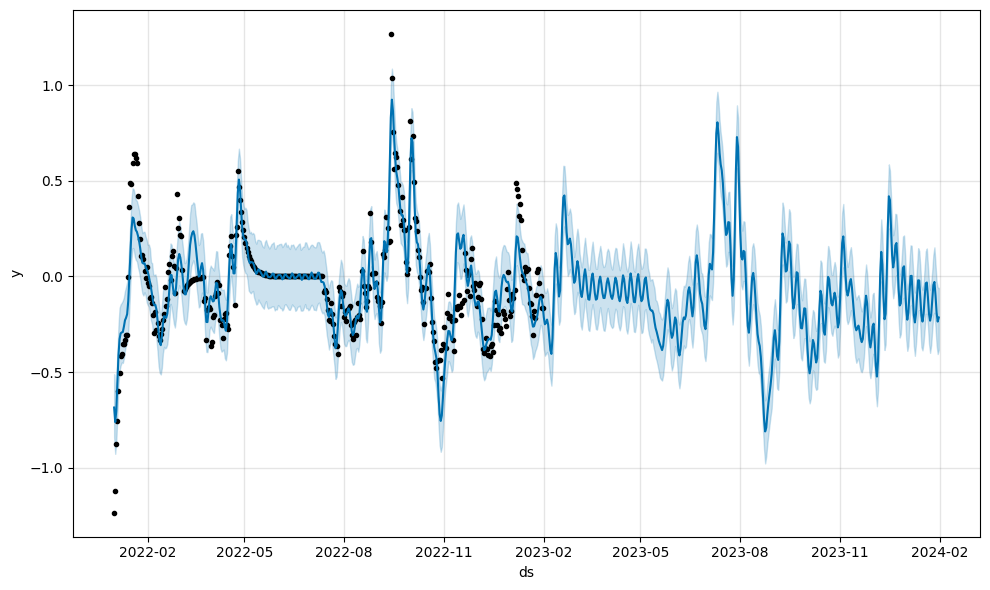

In [56]:
# Построим график реальных значений и предсказанных на тренировочной выборке
future = model.make_future_dataframe(periods=365, freq='D')
forecast = model.predict(future)
model.plot(forecast)


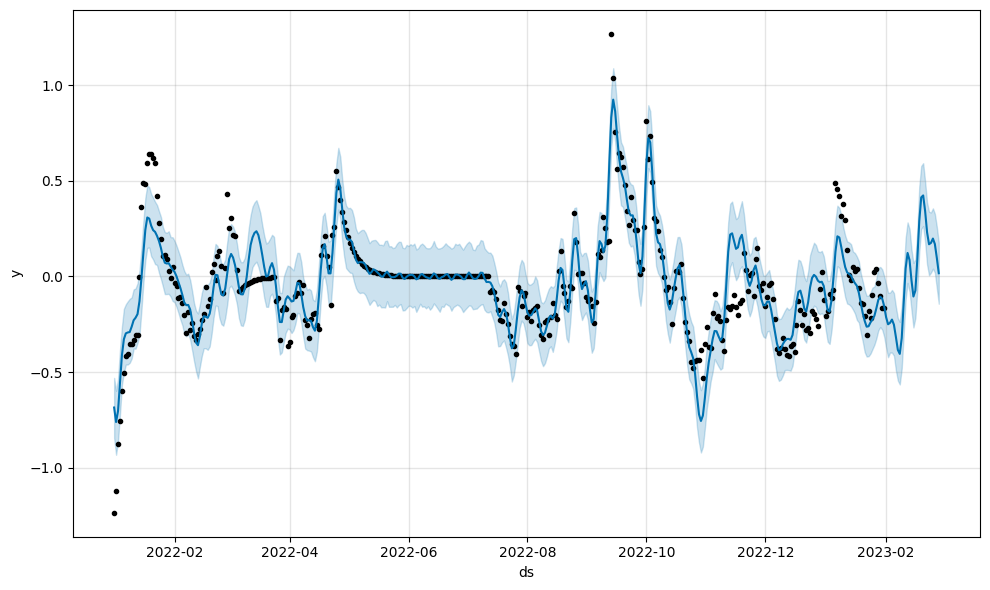

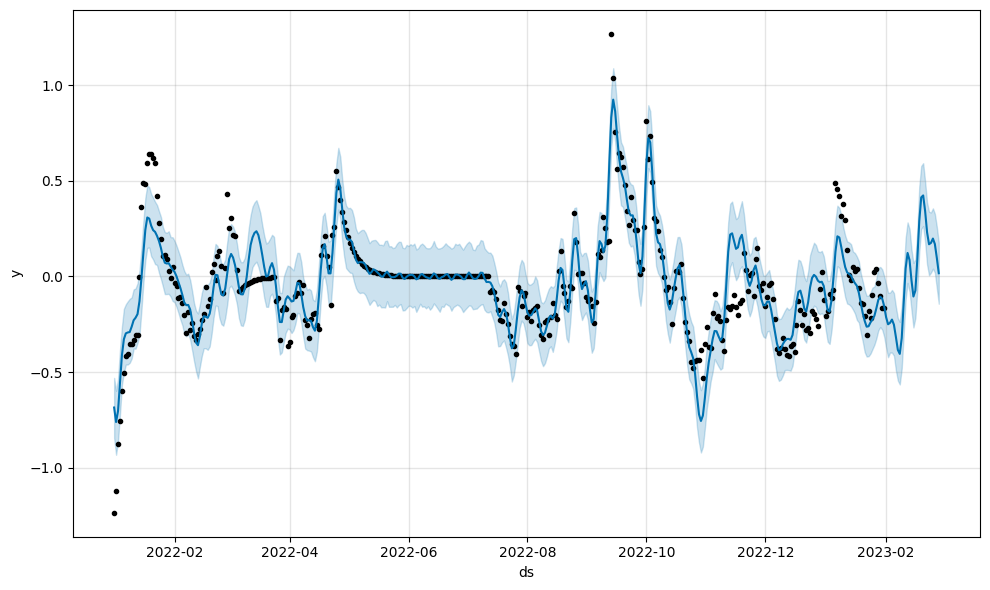

In [57]:
# Предскажем данные еще на месяц
future = model.make_future_dataframe(periods=28, freq='D')
forecast = model.predict(future)
model.plot(forecast)



In [58]:
# Найдем MAE и MAPE
y_true = series
y_pred = forecast['yhat'][:len(series)]
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAE: {mae}')
print(f'MAPE: {mape}')


MAE: 0.08124104773486332
MAPE: 16345.504722860489


In [59]:
# Получим датафрейм из дат и предсказаний
df_forecast = pd.DataFrame({'ds': forecast['ds'], 'y': forecast['yhat']})
df_forecast['ds'] = pd.to_datetime(df_forecast['ds'])

# Вытащим от туда только даты с 2023.02.01 по 2023.02.28
df_forecast = df_forecast[df_forecast['ds'] >= '2023-02-08']
df_forecast

,ds,y
403,2023-02-08,-0.404587
404,2023-02-09,-0.322234
405,2023-02-10,-0.142748
406,2023-02-11,0.041544
407,2023-02-12,0.122790
408,2023-02-13,0.086075
409,2023-02-14,-0.020061
410,2023-02-15,-0.104886
411,2023-02-16,-0.073944
412,2023-02-17,0.087547


In [60]:
# Найдем среднее и стандартное отклонение кешбека для Bonafide из ../tasks/merch_cb_hack_8_9.csv
df_cb = pd.read_csv('../tasks/merch_cb_hack_8_9.csv')
df_cb = df_cb[df_cb['merchant_name'] == 'Bonafide']
df_cb


,merchant_name,day,month,cashback
7,Bonafide,2023-02-02 00:00:00,2023-02-01 00:00:00,311.03
8,Bonafide,2023-02-03 00:00:00,2023-02-01 00:00:00,396.00
9,Bonafide,2023-02-04 00:00:00,2023-02-01 00:00:00,205.73
10,Bonafide,2023-02-05 00:00:00,2023-02-01 00:00:00,186.14
11,Bonafide,2023-02-06 00:00:00,2023-02-01 00:00:00,764.20


In [61]:
# Найдем среднее и стандартное отклонение кешбека для df_cb
mean_cb = df_cb['cashback'].mean()
std_cb = df_cb['cashback'].std()

def denormalize_value(value, mean, std):
    return value * std + mean

# Создадим столбец с кешбеком
df_forecast['cashback'] = df_forecast['y'].apply(lambda x: denormalize_value(x, mean_cb, std_cb))
df_forecast

,ds,y,cashback
403,2023-02-08,-0.404587,277.670948
404,2023-02-09,-0.322234,296.997613
405,2023-02-10,-0.142748,339.119585
406,2023-02-11,0.041544,382.369678
407,2023-02-12,0.122790,401.436565
408,2023-02-13,0.086075,392.820160
409,2023-02-14,-0.020061,367.911963
410,2023-02-15,-0.104886,348.005089
411,2023-02-16,-0.073944,355.266596
412,2023-02-17,0.087547,393.165595
